# HASAR

In [11]:

def loading_geo_data():
    import geopandas as gpd
    import fiona
    import pandas as pd
    pd.options.display.max_columns = 100
    # Path to your .gdb file
    file_path = "./HSR_KSATD2.gdb/"

    # List all layers in the .gdb file
    layers = fiona.listlayers(file_path)
    for layer in layers:
        pass

    # Specify the layer name you're interested in
    layer_name = 'Farms'

    # Read the layer into a GeoDataFrame
    df_farms = gpd.read_file(file_path, layer=layer_name)
    layer_name = 'Property'
    df_property = gpd.read_file(file_path, layer=layer_name)
    layer_name = 'Wells'

    # Read the layer into a GeoDataFrame
    df_wells = gpd.read_file(file_path, layer=layer_name)
    return df_farms, df_property, df_wells


df_farms, df_property, df_wells = loading_geo_data()


In [12]:
df_wells

,HSRCode,OB_HSRCode,PossessionType,IsActive,IrragationSource,IrrigationType,X,Y,Region,geometry
0,05_10_000683,05_00_003440,1,1,2,3.0,48.820924,26.962683,5.0,POINT (283700.298 2984167.59)
1,05_10_000176,05_00_002716,1,1,2,3.0,48.798464,26.956931,5.0,POINT (281459.151 2983568.905)
2,05_10_001562,05_00_001754,1,1,2,1.0,48.828529,26.963245,5.0,POINT (284456.482 2984216.863)
3,05_10_001269,05_00_004920,1,1,2,3.0,48.725944,27.007551,5.0,POINT (274359.078 2989305.743)
4,05_10_002665,05_00_003441,1,1,2,3.0,48.523927,27.148122,5.0,POINT (254613.759 3005261.661)
...,...,...,...,...,...,...,...,...,...,...
30104,10_10_001662,10_00_126431,1,1,2,3.0,42.634884,17.196146,10.0,POINT (-392113.297 1920605.966)
30105,10_10_001663,10_00_126431,1,1,2,3.0,42.635226,17.199678,10.0,POINT (-392059.482 1920998.602)
30106,10_10_001667,10_00_126431,1,1,2,3.0,42.631506,17.198558,10.0,POINT (-392463.956 1920890.889)
30107,10_10_001669,10_00_126431,1,1,2,3.0,42.632024,17.195939,10.0,POINT (-392421.141 1920596.176)


### Processing Wells

In [13]:
# Updated code to handle well_is_active column more robustly

import pandas as pd
import geopandas as gpd

# Assuming df_wells is your GeoDataFrame
# If it's not, convert it first:
# df_wells = gpd.GeoDataFrame(df_wells, geometry='geometry')

# 1. Consistent and clear naming
df_wells = df_wells.rename(
    columns={
        "HSRCode": "well_id",
        "OB_HSRCode": "farm_id",
        "PossessionType": "well_possession_type",
        "IsActive": "well_is_active",
        "IrragationSource": "well_irrigation_source",
        "IrrigationType": "well_irrigation_type",
        "X": "well_longitude",
        "Y": "well_latitude",
        "Region": "well_region",
    }
)



# 3. More nuanced handling of missing and unexpected values
def clean_active_status(value):
    if pd.isna(value) or value == 0:  # Treat 0 as missing data
        return 1  # Assume active if not specified, you may want to change this based on domain knowledge
    elif value in [1, 2]:
        return value
    else:
        print(f"Unexpected value in well_is_active: {value}")
        return 1  # Default to active for unexpected values, adjust as needed

df_wells['well_is_active'] = df_wells['well_is_active'].apply(clean_active_status)

# 4. General function for handling missing values in other columns
def fill_missing(series):
    if pd.api.types.is_numeric_dtype(series):
        return series.fillna(series.median())
    elif pd.api.types.is_object_dtype(series):
        return series.fillna(series.mode()[0] if not series.mode().empty else 'Unknown')
    else:
        return series  # Return as-is for other types (including geometry)

# Apply fill_missing to all columns except the geometry and well_is_active columns
for col in df_wells.columns:
    if col not in [df_wells.geometry.name, 'well_is_active']:
        df_wells[col] = fill_missing(df_wells[col])

# 5. Preserve geographical information
geo_columns = ['well_longitude', 'well_latitude', 'well_region']

# 6. Add data validation
assert df_wells['well_id'].nunique() == len(df_wells), "Duplicate well IDs found"
assert df_wells['well_is_active'].isin([1, 2]).all(), "Invalid values in well_is_active after cleaning"

# 7. Use pandas categorical type for efficiency
categorical_columns = ['well_possession_type', 'well_is_active', 'well_irrigation_source', 'well_irrigation_type']
for col in categorical_columns:
    df_wells[col] = df_wells[col].astype('category')
    df_wells[col] = df_wells[col].replace(0,df_wells[col].mode()[0]).astype('category')

# 8. More flexible aggregation function
def aggregate_wells(group):
    agg_dict = {
        'well_id': 'count',
        'well_is_active': lambda x: (x == 1).sum(),
        'well_irrigation_source': lambda x: x.value_counts().to_dict(),
        'well_irrigation_type': lambda x: x.value_counts().to_dict(),
    }
    return pd.Series(group.agg(agg_dict))

# Apply the aggregation
df_wells_summary = df_wells.groupby("farm_id").apply(aggregate_wells).reset_index()

# Function to flatten dictionary columns
def flatten_dict_column(df, column_name):
    # Get all unique keys from all dictionaries in the column
    all_keys = set()
    for d in df[column_name]:
        all_keys.update(d.keys())
    
    # Create new columns for each key
    for key in all_keys:
        df[f'{column_name}_{key}'] = df[column_name].apply(lambda d: d.get(key, 0))
    
    # Drop the original dictionary column
    df = df.drop(columns=[column_name])
    return df

# Flatten the dictionary columns
df_wells_summary = flatten_dict_column(df_wells_summary, 'well_irrigation_source')
df_wells_summary = flatten_dict_column(df_wells_summary, 'well_irrigation_type')

# Calculate percentages for irrigation sources and types
well_count = df_wells_summary['well_id']
for col in df_wells_summary.columns:
    if col.startswith('well_irrigation_source_') or col.startswith('well_irrigation_type_'):
        df_wells_summary[f'{col}_percentage'] = df_wells_summary[col] / well_count

# Calculate percentage of active wells
df_wells_summary['active_wells_percentage'] = df_wells_summary['well_is_active'] / df_wells_summary['well_id']

# Remove geographical columns if they exist
columns_to_drop = ['well_longitude', 'well_latitude', 'well_region']
df_wells_summary = df_wells_summary.drop(columns=[col for col in columns_to_drop if col in df_wells_summary.columns])

# 9. Add documentation
"""
This script processes well data, performing the following steps:
1. Renames columns for clarity
2. Examines and cleans the well_is_active column
3. Handles missing values in other columns
4. Validates data integrity
5. Optimizes data types
6. Aggregates data at the farm level, including:
   - Count of wells
   - Count and percentage of active wells
   - Flattened counts and percentages for irrigation sources and types
7. Removes geographical information

Input: GeoDataFrame with individual well data
Output: DataFrame with farm-level well summaries
"""

# print(df_wells_summary.head())
# print(df_wells_summary.columns)

# # Optional: Basic statistics
# print("\nBasic Statistics:")
# print(f"Total number of farms: {len(df_wells_summary)}")
# print(f"Total number of wells: {df_wells_summary['well_id'].sum()}")
# print(f"Average number of wells per farm: {df_wells_summary['well_id'].mean():.2f}")
# print(f"Average percentage of active wells: {df_wells_summary['active_wells_percentage'].mean():.2%}")

# Most common irrigation source and type
most_common_source = df_wells_summary[[col for col in df_wells_summary.columns if col.startswith('well_irrigation_source_') and not col.endswith('_percentage')]].sum().idxmax()
most_common_type = df_wells_summary[[col for col in df_wells_summary.columns if col.startswith('well_irrigation_type_') and not col.endswith('_percentage')]].sum().idxmax()

# print(f"Most common irrigation source: {most_common_source.split('_')[-1]}")
# print(f"Most common irrigation type: {most_common_type.split('_')[-1]}")

df_wells_summary['sprinklers_count'] = df_wells_summary['well_id']
df_wells_summary['sprinklers_count_kw'] = df_wells_summary['well_id'] * 25

df_wells_summary.head()

,farm_id,well_id,well_is_active,well_irrigation_source_1,well_irrigation_source_2,well_irrigation_source_4,well_irrigation_source_5,well_irrigation_source_6,well_irrigation_source_10,well_irrigation_source_12,well_irrigation_type_1.0,well_irrigation_type_2.0,well_irrigation_type_3.0,well_irrigation_type_4.0,well_irrigation_type_6.0,well_irrigation_type_7.0,well_irrigation_source_1_percentage,well_irrigation_source_2_percentage,well_irrigation_source_4_percentage,well_irrigation_source_5_percentage,well_irrigation_source_6_percentage,well_irrigation_source_10_percentage,well_irrigation_source_12_percentage,well_irrigation_type_1.0_percentage,well_irrigation_type_2.0_percentage,well_irrigation_type_3.0_percentage,well_irrigation_type_4.0_percentage,well_irrigation_type_6.0_percentage,well_irrigation_type_7.0_percentage,active_wells_percentage,sprinklers_count,sprinklers_count_kw
0,01_00_000002,5,5,4,1,0,0,0,0,0,4,1,0,0,0,0,0.8,0.2,0.0,0.0,0.0,0.0,0.0,0.8,0.2,0.0,0.0,0.0,0.0,1.0,5,125
1,01_00_000003,5,5,5,0,0,0,0,0,0,5,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5,125
2,01_00_000006,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,25
3,01_00_000008,2,2,1,1,0,0,0,0,0,1,0,1,0,0,0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,1.0,2,50
4,01_00_000009,2,0,2,0,0,0,0,0,0,2,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,50


### Processing Farms

In [14]:
import pandas as pd
import geopandas as gpd
import numpy as np



# Rename columns
rename_dict = {
    'HSRCode': 'activity_id',
    'OB_HSRCode': 'farm_id',
    'ActivityStatus': 'activity_status',
    'FarmType': 'farm_type',
    'MainCropsType': 'main_crop_type',
    'CropsType': 'crop_type',
    'IrragationSource': 'irrigation_source',
    'IrragationType': 'irrigation_type',
    'FarmingSeason': 'farming_season',
    'TotalArea': 'total_area_hectares',
    'ProductiveTreesNo': 'productive_trees_count',
    'ProtectedHouseNo': 'protected_house_count',
    'ProtectedHouseType': 'protected_house_type',
    'PlantationsNo': 'plantations_count',
    'PlantationsType': 'plantations_type'
}
df_farms = df_farms.rename(columns={k: v for k, v in rename_dict.items() if k in df_farms.columns})

def safe_float(x):
    if pd.isna(x) or x == '':
        return np.nan
    try:
        return float(x)
    except ValueError:
        return np.nan

# Handle numeric columns
numeric_columns = ['total_area_hectares', 'productive_trees_count', 'protected_house_count', 'plantations_count', 'SHAPE_Length', 'SHAPE_Area']
numeric_columns = [col for col in numeric_columns if col in df_farms.columns]
for col in numeric_columns:
    df_farms[col] = df_farms[col].apply(safe_float)

# Handle categorical columns
categorical_columns = ['activity_status', 'farm_type', 'main_crop_type', 'irrigation_source', 'irrigation_type', 'farming_season', 'protected_house_type', 'plantations_type']
categorical_columns = [col for col in categorical_columns if col in df_farms.columns]
for col in categorical_columns:
    df_farms[col] = df_farms[col].fillna(df_farms[col].mode()[0]).astype('category')
    df_farms[col] = df_farms[col].replace(0, df_farms[col].mode()[0]).astype('category')
    df_farms[col] = df_farms[col].astype('category')

# Create dummy variables for categorical columns
df_farms = pd.get_dummies(df_farms, columns=categorical_columns, prefix_sep='_', dtype=int)

# Prepare aggregation dictionary
agg_dict = {
    'activity_id': 'nunique',
    'crop_type': 'nunique',
    'X': 'first',
    'Y': 'first'
}
agg_dict.update({col: 'sum' for col in numeric_columns})

# Add dummy columns to aggregation dictionary
dummy_columns = [col for col in df_farms.columns if '_' in col and col not in ['farm_id', 'activity_id', 'crop_type']]
agg_dict.update({col: 'sum' for col in dummy_columns})

# Group by farm_id and aggregate
df_farms_summary = df_farms.groupby('farm_id').agg(agg_dict)

# Rename columns for clarity
df_farms_summary = df_farms_summary.rename(columns={
    'activity_id': 'activity_count',
    'crop_type': 'unique_crop_types_count'
})



df_farms_summary = df_farms_summary.drop(columns=["X", "Y", "SHAPE_Length", "SHAPE_Area",])
df_farms_summary

,activity_count,unique_crop_types_count,total_area_hectares,productive_trees_count,protected_house_count,plantations_count,activity_status_1,activity_status_3,activity_status_4,activity_status_6,farm_type_1.0,farm_type_2.0,farm_type_5.0,farm_type_6.0,farm_type_7.0,farm_type_10.0,farm_type_11.0,main_crop_type_1.0,main_crop_type_2.0,main_crop_type_3.0,main_crop_type_4.0,main_crop_type_5.0,main_crop_type_6.0,main_crop_type_7.0,main_crop_type_8.0,main_crop_type_9.0,main_crop_type_10.0,main_crop_type_12.0,main_crop_type_13.0,main_crop_type_14.0,main_crop_type_15.0,irrigation_source_1.0,irrigation_source_2.0,irrigation_source_4.0,irrigation_source_5.0,irrigation_source_6.0,irrigation_source_7.0,irrigation_source_10.0,irrigation_source_12.0,irrigation_type_1.0,irrigation_type_2.0,irrigation_type_3.0,irrigation_type_4.0,irrigation_type_6.0,irrigation_type_7.0,farming_season_1.0,farming_season_2.0,farming_season_3.0,farming_season_4.0,protected_house_type_1.0,protected_house_type_2.0,protected_house_type_3.0,protected_house_type_4.0,protected_house_type_6.0,protected_house_type_7.0,plantations_type_1.0,plantations_type_2.0,plantations_type_3.0
farm_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01_00_000002,6,2,55.035575,594.0,0.0,0.0,4,1,1,0,0,5,0,1,0,0,0,4,1,0,0,0,0,0,0,0,0,0,0,0,1,0,5,0,0,0,0,0,1,4,0,1,0,1,0,4,0,0,2,6,0,0,0,0,0,0,0,6
01_00_000003,5,1,67.494602,0.0,0.0,0.0,5,0,0,0,0,5,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,5,0,0,0,0,0,5,0,0,0,5,0,0,0,0,0,0,0,5
01_00_000006,1,1,30.682688,0.0,0.0,0.0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
01_00_000008,11,3,46.750421,0.0,0.0,0.0,5,6,0,0,9,2,0,0,0,0,0,2,0,0,9,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,2,9,0,0,0,0,4,0,1,6,11,0,0,0,0,0,0,0,11
01_00_000009,2,1,27.911888,0.0,0.0,0.0,2,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13_00_014341,4,2,30.365888,4564.0,0.0,0.0,4,0,0,0,0,1,0,1,2,0,0,1,1,0,0,0,0,0,0,0,2,0,0,0,0,0,4,0,0,0,0,0,0,1,0,3,0,0,0,1,0,3,0,4,0,0,0,0,0,0,0,4
13_00_014422,1,1,13.711515,0.0,0.0,0.0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
13_00_016808,1,1,60.445241,0.0,0.0,0.0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1


### Processing Property

In [15]:
df_property = (
    df_property[["OB_HSRCode", "SHAPE_Area", "MainType"]].rename(
        columns={
            "OB_HSRCode": "farm_id",
            "SHAPE_Area": "property_area",
            "MainType": "property_main_type",
        }
    )
)
df_property

,farm_id,property_area,property_main_type
0,05_00_000030,3.565259e+06,3.0
1,05_00_000090,3.681615e+06,3.0
2,05_00_000051,2.555279e+06,3.0
3,05_00_000067,1.168098e+06,3.0
4,05_00_000177,1.337747e+06,3.0
...,...,...,...
18308,06_00_008951,6.254972e+05,1.0
18309,06_00_008965,8.418189e+05,1.0
18310,06_00_008968,7.502167e+05,1.0
18311,06_00_009342,1.697147e+06,1.0


### Processing Visits

In [16]:
import pandas as pd
import numpy as np

# Load the data
df_visits = pd.read_csv("./processed_data/visits_final.csv")
print(f"\nNumber of rows before processing: {len(df_visits)}")


# Function to safely convert to float
def safe_float(x):
    try:
        return float(x)
    except (ValueError, TypeError):
        return np.nan


# Function to safely convert to int
def safe_int(x):
    try:
        return int(float(x))
    except (ValueError, TypeError):
        return np.nan


# Clean and process the data
def process_visits_data(df):
    # Select only the specified columns
    columns_to_keep = [
        "farm_id",
        "mechanical_head_1_hp",
        "mechanical_head_2_hp",
        "mechanical_head_3_hp",
        "mechanical_head_4_hp",
        "mechanical_head_5_hp",
        "mechanical_head_6_hp",
        "mechanical_head_7_hp",
        "mechanical_head_8_hp",
        "mechanical_head_9_hp",
        "mechanical_head_10_hp",
        "mechanical_head_11_hp",
        "mechanical_head_12_hp",
        "mechanical_head_13_hp",
        "mechanical_head_14_hp",
        "mechanical_head_15_hp",
        "total_mechanical_head_hp",
        #"total_mechanical_head_kw",
        "electrical_head_1_hp",
        "electrical_head_2_hp",
        "electrical_head_3_hp",
        "electrical_head_4_hp",
        "electrical_head_5_hp",
        "electrical_head_6_hp",
        "total_electrical_head_hp",
        #"total_electrical_head_kw",
        "water_level_sensor_1_hp",
        "water_level_sensor_2_hp",
        "water_level_sensor_3_hp",
        "water_level_sensor_4_hp",
        "water_level_sensor_5_hp",
        "water_level_sensor_6_hp",
        "water_level_sensor_7_hp",
        "water_level_sensor_8_hp",
        "water_level_sensor_9_hp",
        "water_level_sensor_10_hp",
        "water_level_sensor_11_hp",
        "water_level_sensor_12_hp",
        "water_level_sensor_13_hp",
        "water_level_sensor_14_hp",
        "water_level_sensor_15_hp",
        "water_level_sensor_16_hp",
        "water_level_sensor_17_hp",
        "water_level_sensor_18_hp",
        "water_level_sensor_19_hp",
        "water_level_sensor_20_hp",
        "water_level_sensor_21_hp",
        "total_water_level_sensor_hp",
        #"total_water_level_sensor_kw",
        "pump_1_hp",
        "pump_2_hp",
        "pump_3_hp",
        "pump_4_hp",
        "total_pump_hp",
        #"total_pump_kw",
        "total_electrical_load_kw",
        #"total_electrical_load_kva",
        "mechanical_heads_counts",
        "electrical_heads_counts",
        "water_level_counts",
        "pump_counts",
    ]
    df = df[columns_to_keep]

    # Rename water_level_sensor columns to submersible_pump
    rename_dict = {
        col: col.replace("water_level_sensor", "submersible_pump")
        for col in df.columns
        if "water_level_sensor" in col
    }
    df = df.rename(columns=rename_dict)

    # Convert all numeric columns to float
    numeric_columns = df.columns.drop("farm_id")
    for col in numeric_columns:
        df[col] = df[col].apply(safe_float)
    
    df = df.rename(columns={"water_level_counts": "submersible_pump_counts"})

    # Convert count columns to integers
    count_columns = [
        "mechanical_heads_counts",
        "electrical_heads_counts",
        "submersible_pump_counts",
        "pump_counts",
    ]
    for col in count_columns:
        df[col] = df[col].apply(safe_int)

    # Drop rows where all equipment counts are 0 or NaN
    df = df[
        ~(
            (df["mechanical_heads_counts"].fillna(0) == 0)
            & (df["electrical_heads_counts"].fillna(0) == 0)
            & (df["submersible_pump_counts"].fillna(0) == 0)
            & (df["pump_counts"].fillna(0) == 0)
        )
    ]

    return df


# Process the data
df_visits_processed = process_visits_data(df_visits).fillna(0)

# Print the number of rows before and after filtering
print(f"\nNumber of rows before filtering: {len(df_visits)}")
print(f"Number of rows after filtering: {len(df_visits_processed)}")

df_visits_processed


Number of rows before processing: 17230

Number of rows before filtering: 17230
Number of rows after filtering: 10863


,farm_id,mechanical_head_1_hp,mechanical_head_2_hp,mechanical_head_3_hp,mechanical_head_4_hp,mechanical_head_5_hp,mechanical_head_6_hp,mechanical_head_7_hp,mechanical_head_8_hp,mechanical_head_9_hp,mechanical_head_10_hp,mechanical_head_11_hp,mechanical_head_12_hp,mechanical_head_13_hp,mechanical_head_14_hp,mechanical_head_15_hp,total_mechanical_head_hp,electrical_head_1_hp,electrical_head_2_hp,electrical_head_3_hp,electrical_head_4_hp,electrical_head_5_hp,electrical_head_6_hp,total_electrical_head_hp,submersible_pump_1_hp,submersible_pump_2_hp,submersible_pump_3_hp,submersible_pump_4_hp,submersible_pump_5_hp,submersible_pump_6_hp,submersible_pump_7_hp,submersible_pump_8_hp,submersible_pump_9_hp,submersible_pump_10_hp,submersible_pump_11_hp,submersible_pump_12_hp,submersible_pump_13_hp,submersible_pump_14_hp,submersible_pump_15_hp,submersible_pump_16_hp,submersible_pump_17_hp,submersible_pump_18_hp,submersible_pump_19_hp,submersible_pump_20_hp,submersible_pump_21_hp,total_submersible_pump_hp,pump_1_hp,pump_2_hp,pump_3_hp,pump_4_hp,total_pump_hp,total_electrical_load_kw,mechanical_heads_counts,electrical_heads_counts,submersible_pump_counts,pump_counts
3,01_00_000008,300.0,300.0,300.0,300.0,300.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1800.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1492.80,6,0,0,0
7,01_00_000012,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,0.0,0.0,0.0,150.0,360.70,1,0,0,1
9,01_00_000014,350.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,750.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,609.50,2,0,0,0
10,01_00_000016,425.0,425.0,425.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1275.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1026.15,3,0,0,0
11,01_00_000017,350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,0.0,0.0,0.0,150.0,398.00,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17225,07_00_013777,425.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,425.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,342.05,1,0,0,0
17226,07_00_013781,600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,472.60,1,0,0,0
17227,07_00_013868,425.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,425.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,342.05,1,0,0,0
17228,07_00_013869,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,398.00,1,0,0,0


### Integrating the different datasets

In [9]:
import pandas as pd
import numpy as np

# Assuming all dataframes are already loaded and preprocessed
# df_property, df_farms_summary, df_visits_processed, df_wells_summary

# Start with df_property as the base
df_integrated = df_property.copy()

# Merge with df_farms_summary
df_integrated = df_integrated.merge(df_farms_summary, on='farm_id', how='left')

# Merge with df_wells_summary
df_integrated = df_integrated.merge(df_wells_summary, on='farm_id', how='left')


# Merge with df_visits_processed
df_integrated = df_integrated.merge(df_visits_processed, on='farm_id', how='left')


# Handle missing values
numeric_columns = df_integrated.select_dtypes(include=[np.number]).columns
df_integrated[numeric_columns] = df_integrated[numeric_columns].fillna(0)


# df_integrated.columns.tolist()

## Good solution but not perfect

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer
import warnings
warnings.filterwarnings('ignore')

def evaluate_model(y_true, y_pred, step_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluation metrics for {step_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")

# Load the data
df = df_integrated.copy()

# Separate HASAR features from visits data
hasar_columns = [
    'farm_id', 'property_area', 'property_main_type', 'activity_count', 
    'unique_crop_types_count', 'total_area_hectares', 'productive_trees_count', 
    'protected_house_count', 'plantations_count'
] + [col for col in df.columns if col.startswith(('activity_status_', 'farm_type_', 
    'main_crop_type_', 'irrigation_source_', 'irrigation_type_', 'farming_season_', 
    'protected_house_type_', 'plantations_type_', 'well_'))]

visits_columns = ['total_electrical_load_kw']

df_hasar = df[hasar_columns]
df_visits = df[['farm_id', 'total_electrical_load_kw']]

# Handle missing values in HASAR data
# imputer = KNNImputer(n_neighbors=5)
# df_hasar_imputed = pd.DataFrame(imputer.fit_transform(df_hasar), columns=df_hasar.columns)
df_hasar_imputed = df_hasar.copy()
# Normalize numerical features
scaler = StandardScaler()
numerical_features = df_hasar_imputed.select_dtypes(include=[np.number]).columns
df_hasar_imputed[numerical_features] = scaler.fit_transform(df_hasar_imputed[numerical_features])

# Feature selection
features = [col for col in df_hasar_imputed.columns if col not in ['farm_id']]
selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold='median')
selector = selector.fit(df_hasar_imputed[features], df_visits['total_electrical_load_kw'])
selected_features = df_hasar_imputed[features].columns[selector.get_support()]
print(selected_features)
# Prepare data for modeling
X = df_hasar_imputed[selected_features]
y = df_visits['total_electrical_load_kw']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models and parameter grids
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR()
}

param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'epsilon': [0.1, 0.2, 0.3],
        'kernel': ['rbf', 'linear']
    }
}

# Perform RandomizedSearchCV for each model
best_model = None
best_score = float('-inf')

for name, model in models.items():
    print(f"\nTuning {name}...")
    random_search = RandomizedSearchCV(model, param_distributions=param_grids[name],
                                       n_iter=20, cv=5, scoring='neg_mean_squared_error',
                                       random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    
    # Evaluate the best model from the random search
    y_pred = random_search.best_estimator_.predict(X_test)
    evaluate_model(y_test, y_pred, f"{name} (after tuning)")
    
    # Update the best model if this one performed better
    score = r2_score(y_test, y_pred)
    if score > best_score:
        best_score = score
        best_model = random_search.best_estimator_

# Use the best model to make final predictions
df_hasar_imputed['estimated_total_electrical_load_kw'] = best_model.predict(df_hasar_imputed[selected_features])

# Merge predictions with actual values
results = pd.merge(df_hasar_imputed[['farm_id', 'estimated_total_electrical_load_kw']], 
                   df_visits, on='farm_id', how='left')

# Print results
print("\nSummary statistics of actual vs estimated total electrical load:")
print(results[['total_electrical_load_kw', 'estimated_total_electrical_load_kw']].describe())

# Calculate final evaluation metrics
final_predictions = results.dropna()
evaluate_model(final_predictions['total_electrical_load_kw'], 
               final_predictions['estimated_total_electrical_load_kw'], 
               "Final Model")

# Save the results
results.to_csv('hasar_only_farm_consumption_estimates.csv', index=False)

# Print feature importances
if hasattr(best_model, 'feature_importances_'):
    importances = pd.DataFrame({'feature': selected_features, 
                                'importance': best_model.feature_importances_})
    importances = importances.sort_values('importance', ascending=False)
    print("\nTop 10 most important features:")
    print(importances.head(10))

Index(['property_area', 'property_main_type', 'activity_count',
       'unique_crop_types_count', 'total_area_hectares',
       'productive_trees_count', 'protected_house_count', 'activity_status_1',
       'activity_status_3', 'farm_type_1.0', 'farm_type_2.0', 'farm_type_6.0',
       'farm_type_7.0', 'main_crop_type_1.0', 'main_crop_type_2.0',
       'main_crop_type_4.0', 'main_crop_type_6.0', 'main_crop_type_8.0',
       'main_crop_type_10.0', 'irrigation_source_1.0', 'irrigation_source_2.0',
       'irrigation_source_12.0', 'irrigation_type_1.0', 'irrigation_type_2.0',
       'irrigation_type_3.0', 'irrigation_type_6.0', 'farming_season_1.0',
       'farming_season_2.0', 'farming_season_3.0', 'farming_season_4.0',
       'protected_house_type_1.0', 'plantations_type_3.0', 'well_id',
       'well_is_active', 'well_irrigation_source_1',
       'well_irrigation_source_2', 'well_irrigation_source_12',
       'well_irrigation_type_1.0', 'well_irrigation_type_3.0',
       'well_irrigation

In [139]:
pd.DataFrame({"predicted": best_model.predict(X_test), "true": y_test}).sample(10)

,predicted,true
10820,0.000000,0.00
5198,337.551629,342.05
11398,213.240099,286.10
700,193.796258,248.80
15394,278.597432,628.15
14508,199.143286,0.00
15348,105.635780,0.00
15108,139.966355,0.00
15800,310.220247,0.00
11668,91.339812,0.00


In [26]:
pd.DataFrame({"predicted": np.expm1(best_pipeline.predict(X_test)), "true": y_test}).sample(10)

,predicted,true
7918,321.019968,472.60
6298,288.419563,248.80
7931,249.261236,118.25
900,580.380229,497.60
7533,147.352533,80.95
10596,277.368693,323.40
8086,301.001844,460.30
4332,183.555337,342.05
5038,485.235380,342.05
3894,382.515866,472.60


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import joblib
import shap

class NonNegativeRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator):
        self.base_estimator = base_estimator

    def fit(self, X, y):
        self.base_estimator.fit(X, y)
        return self

    def predict(self, X):
        predictions = self.base_estimator.predict(X)
        return np.maximum(predictions, 0)

def load_and_preprocess_data(file_path):
    df = df_integrated.copy()
    
    # Top 10 important features based on SHAP values
    important_features = [
        'irrigation_source_2.0', 'total_area_hectares', 'unique_crop_types_count',
        'irrigation_type_2.0', 'property_area', 'productive_trees_count',
        'main_crop_type_6.0', 'activity_count', 'main_crop_type_15.0',
        'irrigation_type_4.0'
    ]
    
    # Add 'farm_id' for joining purposes
    columns_to_keep = ['farm_id'] + important_features
    
    df_hasar = df[columns_to_keep]
    df_target = df[['farm_id', 'total_electrical_load_kw']]
    
    return df_hasar, df_target

def engineer_features(df):
    df['trees_per_hectare'] = df['productive_trees_count'] / df['total_area_hectares']
    df['irrigation_intensity'] = df['irrigation_type_2.0'] * df['total_area_hectares']
    df['well_density'] = df['well_id'] / df['total_area_hectares']
    df['area_per_activity'] = df['total_area_hectares'] / df['activity_count']
    return df

def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', QuantileTransformer(output_distribution='normal'))
            ]), numeric_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features)
        ])
    return preprocessor

def create_ensemble_model():
    gb_model = NonNegativeRegressor(GradientBoostingRegressor(random_state=42))
    rf_model = NonNegativeRegressor(RandomForestRegressor(random_state=42))

    ensemble = VotingRegressor([
        ('gb', gb_model),
        ('rf', rf_model)
    ])
    return ensemble

def evaluate_model(y_true, y_pred, step_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluation metrics for {step_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")

def perform_cross_validation(model, X, y, cv=5):
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    r2_scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error'))
    mae_scores = -cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_absolute_error')
    
    print(f"\nCross-Validation Results (mean ± std):")
    print(f"R2 Score: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
    print(f"RMSE: {rmse_scores.mean():.3f} ± {rmse_scores.std():.3f}")
    print(f"MAE: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

def compute_shap_values(model, X):
    explainer = shap.TreeExplainer(model.estimators_[0].base_estimator)
    shap_values = explainer.shap_values(X)
    
    feature_names = X.columns
    shap_sum = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame(list(zip(feature_names, shap_sum)), columns=['feature', 'importance'])
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    print("\nFeature importance based on SHAP values:")
    print(importance_df)
    
    shap.summary_plot(shap_values, X, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig('shap_summary_plot.png')
    plt.close()

def save_pipeline(pipeline, feature_names, file_path):
    pipeline_data = {
        'pipeline': pipeline,
        'feature_names': feature_names
    }
    joblib.dump(pipeline_data, file_path)

def main():
    # Load and preprocess data
    df_hasar, df_target = load_and_preprocess_data('df_integrated.csv')
    df_hasar = engineer_features(df_hasar)

    # Prepare data for modeling
    X = df_hasar.drop('farm_id', axis=1)
    y = df_target['total_electrical_load_kw']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create preprocessor and model
    preprocessor = create_preprocessor(X)
    ensemble = create_ensemble_model()

    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', ensemble)
    ])

    # Define parameter grid for RandomizedSearchCV
    param_grid = {
        'model__gb__base_estimator__n_estimators': [100, 200, 300],
        'model__gb__base_estimator__max_depth': [3, 4, 5],
        'model__gb__base_estimator__learning_rate': [0.01, 0.1, 0.2],
        'model__rf__base_estimator__n_estimators': [100, 200, 300],
        'model__rf__base_estimator__max_depth': [10, 20, 30, None],
        'model__rf__base_estimator__min_samples_split': [2, 5, 10],
    }

    # Perform RandomizedSearchCV
    random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid,
                                       n_iter=20, cv=5, scoring='neg_mean_squared_error',
                                       random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)

    # Get the best model
    best_pipeline = random_search.best_estimator_

    # Perform cross-validation
    print("\nPerforming cross-validation on the best model:")
    perform_cross_validation(best_pipeline, X, y)

    # Make predictions on the test set
    y_pred_test = best_pipeline.predict(X_test)

    # Evaluate the model on the test set
    print("\nEvaluating the model on the test set:")
    evaluate_model(y_test, y_pred_test, "Best Ensemble Model (Test Set)")

    # Make predictions on the entire dataset
    y_pred_all = best_pipeline.predict(X)

    # Merge predictions with actual values
    results = pd.DataFrame({
        'farm_id': df_hasar['farm_id'],
        'actual_load': df_target['total_electrical_load_kw'],
        'estimated_load': y_pred_all
    })

    # Print summary statistics
    print("\nSummary statistics of actual vs estimated total electrical load:")
    print(results[['actual_load', 'estimated_load']].describe())

    # Calculate final evaluation metrics
    print("\nFinal evaluation metrics on the entire dataset:")
    evaluate_model(results['actual_load'], results['estimated_load'], "Final Ensemble Model (Full Dataset)")

    # Compute SHAP values
    compute_shap_values(best_pipeline.named_steps['model'], X)

    # Save the results
    results.to_csv('ensemble_hasar_farm_consumption_estimates.csv', index=False)

    # Save the pipeline and feature names
    save_pipeline(best_pipeline, X.columns.tolist(), 'hasar_farm_pipeline.joblib')

if __name__ == "__main__":
    main()

KeyError: "['total_electrical_load_kw'] not in index"

In [146]:
# Inference Code Very Important
import pandas as pd
import joblib

def load_pipeline(file_path):
    return joblib.load(file_path)

def inference(pipeline_data, new_data):
    pipeline = pipeline_data['pipeline']
    feature_names = pipeline_data['feature_names']

    # Ensure new_data has all the required features
    for feature in feature_names:
        
        if feature not in new_data.columns:
            print(f"Feature '{feature}' not found in the new data.")
            
            new_data[feature] = 0  # or any appropriate default value

    # Select only the features used during training
    new_data = new_data[feature_names]
    print(new_data)

    # Make predictions
    predictions = pipeline.predict(new_data)

    return predictions

def main():
    # Load the saved pipeline
    pipeline_data = load_pipeline('hasar_farm_pipeline.joblib')

    # Create some sample new data (adjust this according to your feature set)
    new_data = df_integrated.iloc[[3],:]
    

    # Make predictions on new data
    predictions = inference(pipeline_data, new_data)

    print("Predictions for new data:")
    for i, pred in enumerate(predictions):
        print(f"Farm {i+1}: Estimated electrical load: {pred:.2f} kW")

if __name__ == "__main__":
    main()

   irrigation_source_2.0  total_area_hectares  unique_crop_types_count  \
3                    7.0            60.405018                      4.0   

   irrigation_type_2.0  property_area  productive_trees_count  \
3                  0.0   1.168098e+06                   301.0   

   main_crop_type_6.0  activity_count  main_crop_type_15.0  \
3                 0.0             7.0                  0.0   

   irrigation_type_4.0  
3                  0.0  
Predictions for new data:
Farm 1: Estimated electrical load: 264.95 kW


In [17]:
df_integrated = df_property.copy()

# Merge with df_farms_summary
df_integrated = df_integrated.merge(df_farms_summary, on='farm_id', how='left')

# Merge with df_wells_summary
df_integrated = df_integrated.merge(df_wells_summary, on='farm_id', how='left')

In [18]:
df_integrated.head()

,farm_id,property_area,property_main_type,activity_count,unique_crop_types_count,total_area_hectares,productive_trees_count,protected_house_count,plantations_count,activity_status_1,activity_status_3,activity_status_4,activity_status_6,farm_type_1.0,farm_type_2.0,farm_type_5.0,farm_type_6.0,farm_type_7.0,farm_type_10.0,farm_type_11.0,main_crop_type_1.0,main_crop_type_2.0,main_crop_type_3.0,main_crop_type_4.0,main_crop_type_5.0,main_crop_type_6.0,main_crop_type_7.0,main_crop_type_8.0,main_crop_type_9.0,main_crop_type_10.0,main_crop_type_12.0,main_crop_type_13.0,main_crop_type_14.0,main_crop_type_15.0,irrigation_source_1.0,irrigation_source_2.0,irrigation_source_4.0,irrigation_source_5.0,irrigation_source_6.0,irrigation_source_7.0,irrigation_source_10.0,irrigation_source_12.0,irrigation_type_1.0,irrigation_type_2.0,irrigation_type_3.0,irrigation_type_4.0,irrigation_type_6.0,irrigation_type_7.0,farming_season_1.0,farming_season_2.0,farming_season_3.0,farming_season_4.0,protected_house_type_1.0,protected_house_type_2.0,protected_house_type_3.0,protected_house_type_4.0,protected_house_type_6.0,protected_house_type_7.0,plantations_type_1.0,plantations_type_2.0,plantations_type_3.0,well_id,well_is_active,well_irrigation_source_1,well_irrigation_source_2,well_irrigation_source_4,well_irrigation_source_5,well_irrigation_source_6,well_irrigation_source_10,well_irrigation_source_12,well_irrigation_type_1.0,well_irrigation_type_2.0,well_irrigation_type_3.0,well_irrigation_type_4.0,well_irrigation_type_6.0,well_irrigation_type_7.0,well_irrigation_source_1_percentage,well_irrigation_source_2_percentage,well_irrigation_source_4_percentage,well_irrigation_source_5_percentage,well_irrigation_source_6_percentage,well_irrigation_source_10_percentage,well_irrigation_source_12_percentage,well_irrigation_type_1.0_percentage,well_irrigation_type_2.0_percentage,well_irrigation_type_3.0_percentage,well_irrigation_type_4.0_percentage,well_irrigation_type_6.0_percentage,well_irrigation_type_7.0_percentage,active_wells_percentage,sprinklers_count,sprinklers_count_kw
0,05_00_000030,3.565259e+06,3.0,1.0,0.0,0.610111,180.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.00,0.0,0.0,0.0,0.0,1.0,25.0
1,05_00_000090,3.681615e+06,3.0,6.0,1.0,165.999277,0.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.00,0.0,0.0,0.0,0.0,5.0,125.0
2,05_00_000051,2.555279e+06,3.0,2.0,1.0,33.405429,586.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,0.00,0.0,0.0,0.0,1.0,1.0,25.0
3,05_00_000067,1.168098e+06,3.0,7.0,4.0,60.405018,301.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,1.0,0.0,0.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,5.0,2.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,4.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.25,0.0,0.0,0.0,0.5,4.0,100.0
4,05_00_000177,1.337747e+06,3.0,1.0,0.0,0.663144,60.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Load and prepare your features (HASAR data only)
df_features = df_integrated.copy()  # Now, df_integrated contains only HASAR data

# Load your target variable
df_target = df_visits_processed[['farm_id', 'total_electrical_load_kw']]

# Merge features and target on 'farm_id'
df_merged = pd.merge(df_features, df_target, on='farm_id', how='inner')

# Separate features and target
X = df_merged.drop(columns=['farm_id', 'total_electrical_load_kw'])
y = df_merged['total_electrical_load_kw']

# Ensure that 'total_electrical_load_kw' is not present in X
assert 'total_electrical_load_kw' not in X.columns

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42))),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Set up hyperparameter grid for RandomizedSearchCV
param_grid = {
    'feature_selection__estimator__n_estimators': [100, 200],
    'feature_selection__estimator__max_depth': [None, 10, 20],
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid,
                                   n_iter=10, cv=5, scoring='neg_mean_squared_error',
                                   random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Evaluate the model
best_pipeline = random_search.best_estimator_
y_pred = best_pipeline.predict(X_test)

def evaluate_model(y_true, y_pred, step_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluation metrics for {step_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")

evaluate_model(y_test, y_pred, "Random Forest with Proper Preprocessing")

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_pipeline, X, y, cv=cv, scoring='r2')
print(f"Cross-validated R2 scores: {cv_scores}")
print(f"Mean R2 score: {cv_scores.mean()}")



Evaluation metrics for Random Forest with Proper Preprocessing:
MAE: 134.24
RMSE: 231.06
R2 Score: 0.26
Cross-validated R2 scores: [0.26647843 0.28327069 0.36628626 0.27237706 0.35024165]
Mean R2 score: 0.30773081740193775


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

import xgboost as xgb
from xgboost import XGBRegressor

# Load and prepare your features (assuming df_integrated contains the features)
df_features = df_integrated.copy()

# Load your target variable (assuming df_visits_processed contains the target variable)
df_target = df_visits_processed[['farm_id', 'total_electrical_load_kw']]

# Merge features and target on 'farm_id'
df_merged = pd.merge(df_features, df_target, on='farm_id', how='inner')

# List of new features to be created and the required columns for each
new_features = {
    'trees_per_hectare': ['productive_trees_count', 'total_area_hectares'],
    'irrigation_intensity': ['irrigation_type_2.0', 'total_area_hectares'],
    'well_density': ['well_id', 'total_area_hectares'],
    'area_per_activity': ['total_area_hectares', 'activity_count']
}

# Check if required columns exist and create features if they do
for feature_name, required_cols in new_features.items():
    missing_cols = [col for col in required_cols if col not in df_merged.columns]
    if missing_cols:
        print(f"Cannot create feature '{feature_name}' because the following columns are missing: {missing_cols}")
        # Assign default value or decide how to handle missing columns
        df_merged[feature_name] = 0
    else:
        # Handle potential division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            if feature_name == 'trees_per_hectare':
                df_merged[feature_name] = df_merged['productive_trees_count'] / df_merged['total_area_hectares']
            elif feature_name == 'irrigation_intensity':
                df_merged[feature_name] = df_merged['irrigation_type_2.0'] * df_merged['total_area_hectares']
            elif feature_name == 'well_density':
                df_merged[feature_name] = df_merged['well_id'] / df_merged['total_area_hectares']
            elif feature_name == 'area_per_activity':
                df_merged[feature_name] = df_merged['total_area_hectares'] / df_merged['activity_count']

# Replace infinite and NaN values resulting from division by zero
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged.fillna(0, inplace=True)

# Separate features and target
X = df_merged.drop(columns=['farm_id', 'total_electrical_load_kw'])
y = df_merged['total_electrical_load_kw']

# Apply log transformation to the target variable
y_log = np.log1p(y)  # Use log1p to handle zero values

# Ensure that 'total_electrical_load_kw' is not present in X
assert 'total_electrical_load_kw' not in X.columns

# Split the data
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Define numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()


# Define preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model pipelines
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Set up hyperparameter grids
param_grid_rf = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt']
}

param_grid_xgb = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0]
}

# Perform RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_grid_rf,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
random_search_rf.fit(X_train, y_train_log)

# Perform RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_grid_xgb,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
random_search_xgb.fit(X_train, y_train_log)

# Best models
best_pipeline_rf = random_search_rf.best_estimator_
best_pipeline_xgb = random_search_xgb.best_estimator_

# Make predictions on the test set
y_pred_log_rf = best_pipeline_rf.predict(X_test)
y_pred_rf = np.expm1(y_pred_log_rf)

y_pred_log_xgb = best_pipeline_xgb.predict(X_test)
y_pred_xgb = np.expm1(y_pred_log_xgb)

# Inverse transform the test target variable
y_test_actual = np.expm1(y_test_log)

def evaluate_model(y_true, y_pred, step_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluation metrics for {step_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")

# Evaluate Random Forest
evaluate_model(y_test_actual, y_pred_rf, "Random Forest with Log-Transformed Target")

# Evaluate XGBoost
evaluate_model(y_test_actual, y_pred_xgb, "XGBoost with Log-Transformed Target")

# Ensemble predictions
y_pred_ensemble = (y_pred_rf + y_pred_xgb) / 2

# Evaluate Ensemble Model
evaluate_model(y_test_actual, y_pred_ensemble, "Ensemble Model (Average of RF and XGBoost)")

# Cross-validation for Ensemble Model
mae_scores = []
rmse_scores = []
r2_scores = []

cv = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in cv.split(X):
    X_cv_train, X_cv_test = X.iloc[train_index], X.iloc[test_index]
    y_cv_train_log, y_cv_test_log = y_log.iloc[train_index], y_log.iloc[test_index]
    y_cv_test_actual = np.expm1(y_cv_test_log)
    
    # Fit Random Forest
    best_pipeline_rf.fit(X_cv_train, y_cv_train_log)
    y_pred_log_rf_cv = best_pipeline_rf.predict(X_cv_test)
    y_pred_rf_cv = np.expm1(y_pred_log_rf_cv)
    
    # Fit XGBoost
    best_pipeline_xgb.fit(X_cv_train, y_cv_train_log)
    y_pred_log_xgb_cv = best_pipeline_xgb.predict(X_cv_test)
    y_pred_xgb_cv = np.expm1(y_pred_log_xgb_cv)
    
    # Ensemble predictions
    y_pred_ensemble_cv = (y_pred_rf_cv + y_pred_xgb_cv) / 2
    
    # Evaluate
    mae = mean_absolute_error(y_cv_test_actual, y_pred_ensemble_cv)
    rmse = np.sqrt(mean_squared_error(y_cv_test_actual, y_pred_ensemble_cv))
    r2 = r2_score(y_cv_test_actual, y_pred_ensemble_cv)
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Display cross-validated metrics
print(f"\nCross-validated MAE scores: {mae_scores}")
print(f"Mean MAE score: {np.mean(mae_scores):.2f}")

print(f"Cross-validated RMSE scores: {rmse_scores}")
print(f"Mean RMSE score: {np.mean(rmse_scores):.2f}")

print(f"Cross-validated R2 scores: {r2_scores}")
print(f"Mean R2 score: {np.mean(r2_scores):.4f}")



Evaluation metrics for Random Forest with Log-Transformed Target:
MAE: 128.00
RMSE: 231.47
R2 Score: 0.2572

Evaluation metrics for XGBoost with Log-Transformed Target:
MAE: 128.41
RMSE: 230.75
R2 Score: 0.2618

Evaluation metrics for Ensemble Model (Average of RF and XGBoost):
MAE: 127.77
RMSE: 230.58
R2 Score: 0.2629

Cross-validated MAE scores: [np.float64(127.86668184059518), np.float64(116.32097868705357), np.float64(125.22360248753327), np.float64(117.52431171581881), np.float64(124.86118322045898)]
Mean MAE score: 122.36
Cross-validated RMSE scores: [np.float64(230.3008640957222), np.float64(186.66850561685018), np.float64(217.65893459932042), np.float64(191.74844609860295), np.float64(219.84601191558275)]
Mean RMSE score: 209.24
Cross-validated R2 scores: [0.264675503835313, 0.31073813222110114, 0.30056249542328617, 0.30267784762722205, 0.2596681101232138]
Mean R2 score: 0.2877


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Load and prepare your features (assuming df_integrated contains the features)
df_features = df_integrated.copy()

# Load your target variable (assuming df_visits_processed contains the target variable)
df_target = df_visits_processed[['farm_id', 'total_electrical_load_kw']]

# Merge features and target on 'farm_id'
df_merged = pd.merge(df_features, df_target, on='farm_id', how='inner')

# List of new features to be created and the required columns for each
new_features = {
    'trees_per_hectare': ['productive_trees_count', 'total_area_hectares'],
    'irrigation_intensity': ['irrigation_type_2.0', 'total_area_hectares'],
    'well_density': ['well_id', 'total_area_hectares'],
    'area_per_activity': ['total_area_hectares', 'activity_count']
}

# Check if required columns exist and create features if they do
for feature_name, required_cols in new_features.items():
    missing_cols = [col for col in required_cols if col not in df_merged.columns]
    if missing_cols:
        print(f"Cannot create feature '{feature_name}' because the following columns are missing: {missing_cols}")
        # Assign default value or decide how to handle missing columns
        df_merged[feature_name] = 0
    else:
        # Handle potential division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            if feature_name == 'trees_per_hectare':
                df_merged[feature_name] = df_merged['productive_trees_count'] / df_merged['total_area_hectares']
            elif feature_name == 'irrigation_intensity':
                df_merged[feature_name] = df_merged['irrigation_type_2.0'] * df_merged['total_area_hectares']
            elif feature_name == 'well_density':
                df_merged[feature_name] = df_merged['well_id'] / df_merged['total_area_hectares']
            elif feature_name == 'area_per_activity':
                df_merged[feature_name] = df_merged['total_area_hectares'] / df_merged['activity_count']

# Replace infinite and NaN values resulting from division by zero
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged.fillna(0, inplace=True)

# Separate features and target
X = df_merged.drop(columns=['farm_id', 'total_electrical_load_kw'])
y = df_merged['total_electrical_load_kw']

# Apply log transformation to the target variable
y_log = np.log1p(y)  # Use log1p to handle zero values

# Ensure that 'total_electrical_load_kw' is not present in X
assert 'total_electrical_load_kw' not in X.columns

# Split the data
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Define numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Set up hyperparameter grid for RandomizedSearchCV
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train_log)

# Evaluate the model
best_rf_pipeline = random_search.best_estimator_

# Make predictions on the test set
y_pred_log = best_rf_pipeline.predict(X_test)

# Inverse transform the predictions
y_pred = np.expm1(y_pred_log)  # Use expm1 to reverse log1p

# Inverse transform the test target variable
y_test_actual = np.expm1(y_test_log)

def evaluate_model(y_true, y_pred, step_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluation metrics for {step_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")

evaluate_model(y_test_actual, y_pred, "Random Forest with New Features and Log-Transformed Target")

# Perform cross-validation on the full dataset
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_rf_pipeline, X, y_log, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)

# Convert negative MSE scores to positive RMSE scores
cv_rmse_scores = np.sqrt(-cv_scores)

print(f"Cross-validated RMSE scores: {cv_rmse_scores}")
print(f"Mean RMSE score: {cv_rmse_scores.mean()}")

# Compute R2 scores during cross-validation
cv_r2_scores = cross_val_score(best_rf_pipeline, X, y_log, cv=cv, scoring='r2', n_jobs=-1)
print(f"Cross-validated R2 scores: {cv_r2_scores}")
print(f"Mean R2 score: {cv_r2_scores.mean()}")



Evaluation metrics for Random Forest with New Features and Log-Transformed Target:
MAE: 128.13
RMSE: 232.30
R2 Score: 0.25
Cross-validated RMSE scores: [0.51361942 0.52386038 0.51411386 0.52839404 0.53692943]
Mean RMSE score: 0.5233834277109941
Cross-validated R2 scores: [0.37659321 0.37102605 0.37849301 0.37203678 0.3444576 ]
Mean R2 score: 0.3685213301516555


In [23]:
from xgboost import XGBRegressor

# Update the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42))
])

# Hyperparameter grid
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.7, 0.8, 1.0]
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid,
                                   n_iter=20, cv=5, scoring='neg_mean_squared_error',
                                   random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train_log)

# Evaluate
best_xgboost_pipeline = random_search.best_estimator_
y_pred = best_xgboost_pipeline.predict(X_test)
evaluate_model(y_test_log, y_pred, "XGBoost with Proper Preprocessing")



Evaluation metrics for XGBoost with Proper Preprocessing:
MAE: 0.38
RMSE: 0.51
R2 Score: 0.38


In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor



# Load and prepare your features (assuming df_integrated contains the features)
df_features = df_integrated.copy()

# Load your target variable (assuming df_visits_processed contains the target variable)
df_target = df_visits_processed[['farm_id', 'total_electrical_load_kw']]

# Merge features and target on 'farm_id'
df_merged = pd.merge(df_features, df_target, on='farm_id', how='inner')

# List of new features to be created and the required columns for each
new_features = {
    'trees_per_hectare': ['productive_trees_count', 'total_area_hectares'],
    'irrigation_intensity': ['irrigation_type_2.0', 'total_area_hectares'],
    'well_density': ['well_id', 'total_area_hectares'],
    'area_per_activity': ['total_area_hectares', 'activity_count']
}

# Check if required columns exist and create features if they do
for feature_name, required_cols in new_features.items():
    missing_cols = [col for col in required_cols if col not in df_merged.columns]
    if missing_cols:
        print(f"Cannot create feature '{feature_name}' because the following columns are missing: {missing_cols}")
        # Assign default value or decide how to handle missing columns
        df_merged[feature_name] = 0
    else:
        # Handle potential division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            if feature_name == 'trees_per_hectare':
                df_merged[feature_name] = df_merged['productive_trees_count'] / df_merged['total_area_hectares']
            elif feature_name == 'irrigation_intensity':
                df_merged[feature_name] = df_merged['irrigation_type_2.0'] * df_merged['total_area_hectares']
            elif feature_name == 'well_density':
                # Ensure well_id is a count, not an identifier
                if 'well_id' in df_merged.columns:
                    df_merged[feature_name] = df_merged['well_id'] / df_merged['total_area_hectares']
                else:
                    print(f"Cannot create feature '{feature_name}' because 'well_id' column is missing.")
                    df_merged[feature_name] = 0
            elif feature_name == 'area_per_activity':
                df_merged[feature_name] = df_merged['total_area_hectares'] / df_merged['activity_count']

# Replace infinite and NaN values resulting from division by zero
df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
df_merged.fillna(0, inplace=True)

# Separate features and target
X = df_merged.drop(columns=['farm_id', 'total_electrical_load_kw'])
y = df_merged['total_electrical_load_kw']

# Apply log transformation to the target variable
y_log = np.log1p(y)  # Use log1p to handle zero values

# Ensure that 'total_electrical_load_kw' is not present in X
assert 'total_electrical_load_kw' not in X.columns

# Split the data
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Define numeric and categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the base learners
# Random Forest pipeline
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# XGBoost pipeline
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# Hyperparameter grids
param_grid_rf = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt', 'log2']
}

param_grid_xgb = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.7, 0.8, 1.0],
    'regressor__colsample_bytree': [0.7, 0.8, 1.0]
}

# Perform RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_grid_rf,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
random_search_rf.fit(X_train, y_train_log)

# Perform RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_grid_xgb,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
random_search_xgb.fit(X_train, y_train_log)

# Best estimators
best_pipeline_rf = random_search_rf.best_estimator_
best_pipeline_xgb = random_search_xgb.best_estimator_

# Define the stacking regressor
estimators = [
    ('rf', best_pipeline_rf),
    ('xgb', best_pipeline_xgb)
]

stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    n_jobs=-1
)

# Fit the stacking regressor
stacking_regressor.fit(X_train, y_train_log)

# Make predictions
y_pred_log_stack = stacking_regressor.predict(X_test)
y_pred_stack = np.expm1(y_pred_log_stack)

# Inverse transform the test target variable
y_test_actual = np.expm1(y_test_log)

# Evaluate the stacking regressor
def evaluate_model(y_true, y_pred, step_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\nEvaluation metrics for {step_name}:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")

# Evaluate individual models
# Random Forest
y_pred_log_rf = best_pipeline_rf.predict(X_test)
y_pred_rf = np.expm1(y_pred_log_rf)
evaluate_model(y_test_actual, y_pred_rf, "Random Forest with Log-Transformed Target")

# XGBoost
y_pred_log_xgb = best_pipeline_xgb.predict(X_test)
y_pred_xgb = np.expm1(y_pred_log_xgb)
evaluate_model(y_test_actual, y_pred_xgb, "XGBoost with Log-Transformed Target")

# Evaluate stacking regressor
evaluate_model(y_test_actual, y_pred_stack, "Stacking Regressor (Meta-Learner)")

# Cross-validation for stacking regressor
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacking_regressor, X, y_log, cv=cv, scoring='r2', n_jobs=-1)
print(f"\nCross-validated R2 scores for Stacking Regressor: {cv_scores}")
print(f"Mean R2 score: {cv_scores.mean():.4f}")



Evaluation metrics for Random Forest with Log-Transformed Target:
MAE: 128.13
RMSE: 232.30
R2 Score: 0.2518

Evaluation metrics for XGBoost with Log-Transformed Target:
MAE: 128.56
RMSE: 231.18
R2 Score: 0.2591

Evaluation metrics for Stacking Regressor (Meta-Learner):
MAE: 127.66
RMSE: 229.64
R2 Score: 0.2689

Cross-validated R2 scores for Stacking Regressor: [0.38590447 0.37555954 0.38793434 0.37973505 0.35058437]
Mean R2 score: 0.3759


In [64]:
pd.DataFrame({"predicted":  np.expm1( stacking_regressor.predict(X_test)), "true": y_test_actual}).sample(10)

,predicted,true
1669,287.259978,342.050
9294,324.546024,373.400
7728,233.922269,174.200
2122,359.766455,497.600
3948,355.213031,398.000
6572,227.908869,292.450
7631,175.631927,286.100
2168,245.769790,248.800
5502,195.675831,342.050
7571,94.364151,27.984


<Axes: xlabel='predicted', ylabel='true'>

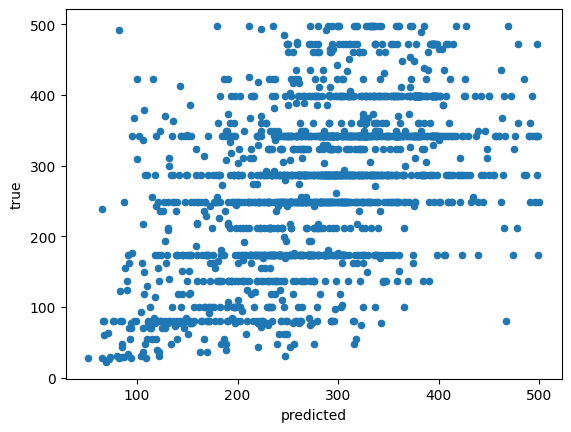

In [71]:
import matplotlib.pyplot as plt

results = pd.DataFrame({"predicted":  np.expm1( stacking_regressor.predict(X_test)), "true": y_test_actual})
# plt.scatter(np.expm1( stacking_regressor.predict(X_test)), y_test_actual)
results[(results["predicted"]<500) & (results["true"]<500)].plot.scatter(x="predicted", y="true")

In [42]:
y_test_actual
mae = mean_absolute_error(y_test_actual, ( np.expm1(best_xgboost_pipeline.predict(X_test)) + np.expm1(best_rf_pipeline.predict(X_test)) ) /2)
rmse = np.sqrt(mean_squared_error(y_test_actual, ( np.expm1(best_xgboost_pipeline.predict(X_test)) + np.expm1(best_rf_pipeline.predict(X_test)) ) /2))
r2 = r2_score(y_test_actual, ( np.expm1(best_xgboost_pipeline.predict(X_test)) + np.expm1(best_rf_pipeline.predict(X_test)) ) /2)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")

MAE: 127.78
RMSE: 230.67
R2 Score: 0.26


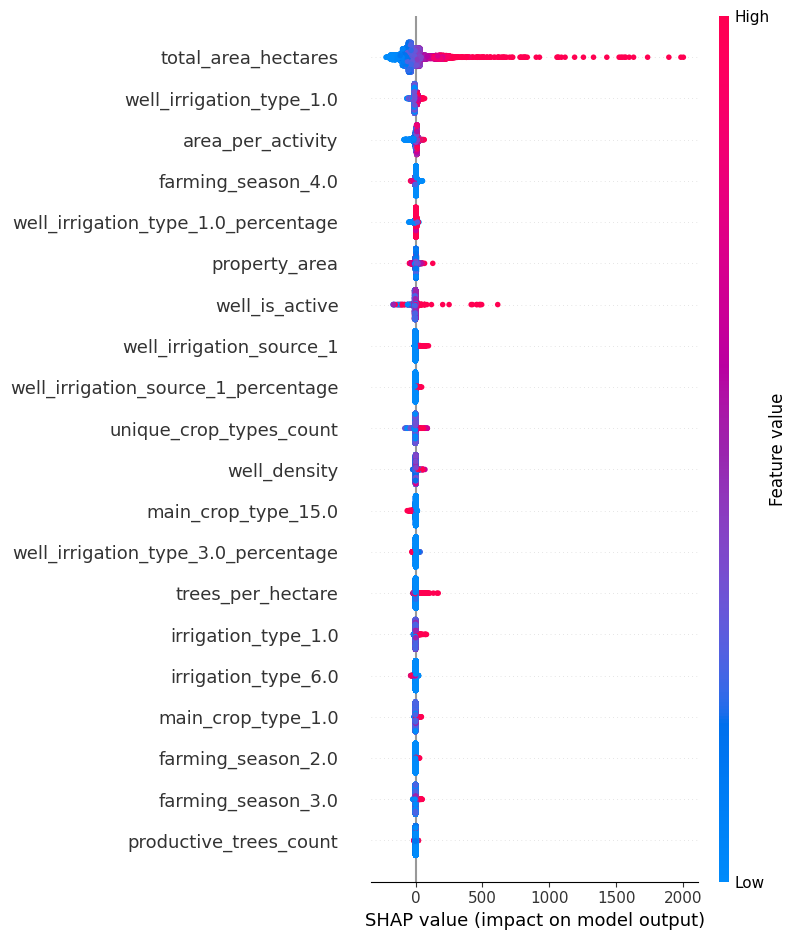

In [30]:
import shap

# Fit the model on the entire training data
best_pipeline.fit(X_train, y_train)

# Extract the model after preprocessing
X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)
model = best_pipeline.named_steps['regressor']

# Create SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_train_transformed)

# Plot SHAP summary
shap.summary_plot(shap_values, X_train_transformed, feature_names=X_train.columns)


In [14]:
print(X_train_transformed)

[[-0.13596224 -0.53326603  0.21410315 ...  0.24698241 -0.74022053
  -0.74022053]
 [-0.56712392  1.64632296 -0.31669039 ...  0.24698241  1.7176766
   1.7176766 ]
 [-0.45133779 -0.53326603 -0.13975921 ...  0.24698241 -0.74022053
  -0.74022053]
 ...
 [ 1.24609868 -0.53326603  3.22193319 ...  0.24698241  9.91066703
   9.91066703]
 [-0.39448087 -0.53326603 -0.49362157 ...  0.24698241 -0.74022053
  -0.74022053]
 [ 2.01763652 -0.53326603  0.56796551 ...  0.24698241  0.89837756
   0.89837756]]


### Here is where I am today, doing this with claude and still has not worked

In [57]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

def process_farms_data(df):
    # Select relevant columns
    columns_to_keep = [
        'farm_id', 'activity_count', 'unique_crop_types_count', 'total_area_hectares',
        'productive_trees_count', 'protected_house_count', 'plantations_count',
        'activity_status_1', 'farm_type_1.0', 'main_crop_type_1.0', 'irrigation_source_2.0',
        'irrigation_type_2.0', 'farming_season_1.0'
    ]
    df = df[columns_to_keep]

    # Check for outliers
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower_bound, upper_bound)

    # Impute missing values
    imputer = KNNImputer(n_neighbors=5)
    df_imputed = df.set_index('farm_id')
    df_imputed = pd.DataFrame(imputer.fit_transform(df_imputed), columns=df_imputed.columns)
    df_imputed = pd.concat([df.reset_index()['farm_id'], df_imputed], axis=1).reset_index(drop=True)
    

    # Feature engineering
    df_imputed['trees_per_hectare'] = df_imputed['productive_trees_count'] / df_imputed['total_area_hectares']
    df_imputed['irrigation_intensity'] = df_imputed['irrigation_type_2.0'] * df_imputed['total_area_hectares']

    return df_imputed

# Load and process the data
df_farms_processed = process_farms_data(df_farms_summary.reset_index())
# df_farms_processed.to_csv("processed_farms_data.csv", index=False)

In [19]:
df_property

,OB_HSRCode,X,Y,MainType,Region,Province,SHAPE_Length,SHAPE_Area,geometry
0,05_00_000030,27.174437,48.713781,3.0,5,509.0,7671.129395,3.565259e+06,"MULTIPOLYGON (((274765.681 3007140.632, 272707..."
1,05_00_000090,27.142062,48.604717,3.0,5,509.0,8237.605854,3.681615e+06,"MULTIPOLYGON (((263199.744 3005454.466, 263600..."
2,05_00_000051,27.263492,48.525035,3.0,5,509.0,6691.140996,2.555279e+06,"MULTIPOLYGON (((256129.043 3017561.571, 253940..."
3,05_00_000067,27.151210,48.576370,3.0,5,509.0,4429.127070,1.168098e+06,"MULTIPOLYGON (((260346.448 3005123.386, 259906..."
4,05_00_000177,27.177854,48.727235,3.0,5,509.0,4626.323985,1.337747e+06,"MULTIPOLYGON (((275211.182 3007620.066, 274647..."
...,...,...,...,...,...,...,...,...,...
18308,06_00_008951,41.563271,18.684821,1.0,6,604.0,3752.247489,6.254972e+05,"MULTIPOLYGON (((-498707.518 2092732.693, -4982..."
18309,06_00_008965,41.565285,18.679834,1.0,6,604.0,4157.116875,8.418189e+05,"MULTIPOLYGON (((-498053.021 2092480.655, -4977..."
18310,06_00_008968,41.560166,18.672380,1.0,6,604.0,3602.602617,7.502167e+05,"MULTIPOLYGON (((-499650.348 2091086.734, -4997..."
18311,06_00_009342,42.828675,20.301142,1.0,6,631.0,5501.131914,1.697147e+06,"MULTIPOLYGON (((-356352.135 2266031.044, -3561..."


In [112]:
df_wells.head()

,HSRCode,OB_HSRCode,PossessionType,IsActive,IrragationSource,IrrigationType,X,Y,Region,geometry
0,05_10_000683,05_00_003440,1,1,2,3.0,48.820924,26.962683,5.0,POINT (283700.298 2984167.59)
1,05_10_000176,05_00_002716,1,1,2,3.0,48.798464,26.956931,5.0,POINT (281459.151 2983568.905)
2,05_10_001562,05_00_001754,1,1,2,1.0,48.828529,26.963245,5.0,POINT (284456.482 2984216.863)
3,05_10_001269,05_00_004920,1,1,2,3.0,48.725944,27.007551,5.0,POINT (274359.078 2989305.743)
4,05_10_002665,05_00_003441,1,1,2,3.0,48.523927,27.148122,5.0,POINT (254613.759 3005261.661)


In [106]:
df_wells.describe()

,PossessionType,IsActive,IrragationSource,IrrigationType,X,Y,Region
count,30109.000000,30109.000000,30109.000000,28845.000000,30109.000000,30109.000000,30107.000000
mean,1.000133,1.044837,1.943904,1.672214,43.594381,25.995777,4.859202
std,0.011526,0.402656,1.540346,1.382752,3.367473,2.877473,3.941056
min,1.000000,0.000000,0.000000,0.000000,35.997507,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,42.393785,24.716648,1.000000
50%,1.000000,1.000000,2.000000,1.000000,44.264056,26.383808,4.000000
75%,1.000000,1.000000,2.000000,3.000000,45.740187,27.658816,7.000000
max,2.000000,2.000000,12.000000,7.000000,50.013522,31.116019,13.000000


In [130]:
import pandas as pd

df = df_wells[["HSRCode", "OB_HSRCode", "PossessionType", "IsActive", "IrragationSource", "IrrigationType"]]
df = df.rename(
    columns={
        "HSRCode": "well_id",
        "OB_HSRCode": "farm_id",
        "PossessionType": "well_possession_type",
        "IsActive": "well_is_active",
        "IrragationSource": "well_irrigation_source",
        "IrrigationType": "well_irrigation_type",

    }
)

df['well_is_active'] = df['well_is_active'].astype('category')
df['well_possession_type'] = df['well_possession_type'].astype('category')
df['well_irrigation_source'] = df['well_irrigation_source'].astype('category')
df['well_irrigation_type'] = df['well_irrigation_type'].astype('category')


def fill_missing(df):
    numeric_columns = df.select_dtypes(include=['int64', 'float64', 'int32', 'int16']).columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    print(f"Numeric Columns: {numeric_columns}")
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())
    df[categorical_columns] = df[categorical_columns].fillna(df[categorical_columns].mode()[0])
    
    return df
# def fill_missing(series):
#     if pd.api.types.is_numeric_dtype(series):
#         return series.fillna(series.median())
#     elif pd.api.types.is_object_dtype(series):
#         return series.fillna(series.mode()[0] if not series.mode().empty else 'Unknown')
#     elif series.dtypes() in ['category']:
        
#     else:
#         return series  

# # Apply fill_missing to all columns except the geometry and well_is_active columns
# for col in df.columns:
#     df[col] = fill_missing(df[col])
#     print(col)
#     print(df[col].isna().sum())

df = fill_missing(df)
# 6. Add data validation
assert df['well_id'].nunique() == len(df), "Duplicate well IDs found"

# 7. Use pandas categorical type for efficiency
categorical_columns = ['well_possession_type', 'well_is_active', 'well_irrigation_source', 'well_irrigation_type']
for col in categorical_columns:
    df[col] = df[col].replace(0,df[col].mode()[0]).astype('category')
    
df['well_irrigation_type'] = df['well_irrigation_type'].astype('int').astype('category')
    
df = pd.get_dummies(data=df, columns=categorical_columns, dtype=int)
print(df.columns.tolist())
# 8. More flexible aggregation function
def aggregate_wells(group):
    agg_dict = {
        'well_id': 'count',
        'well_is_active': lambda x: (x == 1).sum(),
        'well_irrigation_source': lambda x: x.value_counts().to_dict(),
        'well_irrigation_type': lambda x: x.value_counts().to_dict(),
    }
    return pd.Series(group.agg(agg_dict))

# Apply the aggregation
df_wells_summary = df.groupby("farm_id").apply(aggregate_wells).reset_index()






TypeError: 'Index' object is not callable

In [58]:
import pandas as pd
from sklearn.impute import SimpleImputer

def process_property_data(df):
    df_property = df[["OB_HSRCode", "SHAPE_Area", "MainType"]].rename(
        columns={
            "OB_HSRCode": "farm_id",
            "SHAPE_Area": "property_area",
            "MainType": "property_main_type",
        }
    )
    df_property = df_property.set_index("farm_id")

    # Impute missing values
    imputer = SimpleImputer(strategy='median')
    df_property_imputed = pd.DataFrame(imputer.fit_transform(df_property), columns=df_property.columns)
    df_property_imputed = pd.concat([df_property.reset_index()['farm_id'], df_property_imputed], axis=1).reset_index(drop=True)
    return df_property_imputed

# Load and process the data
df_property_processed = process_property_data(df_property)
# df_property_processed.to_csv("processed_property_data.csv", index=False)

In [34]:
df_property_processed

,farm_id,property_area,property_main_type
0,05_00_000030,3.565259e+06,3.0
1,05_00_000090,3.681615e+06,3.0
2,05_00_000051,2.555279e+06,3.0
3,05_00_000067,1.168098e+06,3.0
4,05_00_000177,1.337747e+06,3.0
...,...,...,...
18308,06_00_008951,6.254972e+05,1.0
18309,06_00_008965,8.418189e+05,1.0
18310,06_00_008968,7.502167e+05,1.0
18311,06_00_009342,1.697147e+06,1.0


In [40]:
df_wells.dtypes

HSRCode               object
OB_HSRCode            object
PossessionType         int16
IsActive               int32
IrragationSource       int16
IrrigationType       float64
X                    float64
Y                    float64
Region               float64
geometry            geometry
dtype: object

In [99]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

def process_wells_data(df):
    # Rename columns
    df = df.rename(columns={
        "HSRCode": "well_id",
        "OB_HSRCode": "farm_id",
        "PossessionType": "well_possession_type",
        "IsActive": "well_is_active",
        "IrragationSource": "well_irrigation_source",
        "IrrigationType": "well_irrigation_type",
    })
    
    df["well_possession_type"] = df["well_possession_type"].astype("category")
    df["well_irrigation_type"] = df["well_irrigation_type"].astype("category")

    df = df.set_index("farm_id")
    # Handle missing values
    numeric_columns = df.select_dtypes(include=['int64', 'float64', 'int32', 'int16']).columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    imputer = KNNImputer(n_neighbors=5)
    df_numeric = pd.DataFrame(imputer.fit_transform(df[numeric_columns]), columns=numeric_columns)
    df_categorical = df[categorical_columns].fillna(df[categorical_columns].mode().iloc[0])

    df_imputed = pd.concat([df_numeric, df_categorical], axis=1).set_index("farm_id")
    df_imputed = pd.get_dummies(data=df_imputed, columns=categorical_columns)
    print(df_imputed.head())

    # Aggregate well data by farm
    df_wells_summary = df_imputed.groupby("farm_id").agg({
        'well_id': 'count',
        'well_is_active': lambda x: (x == 1).sum(),
        'well_irrigation_source': lambda x: x.value_counts().to_dict(),
        'well_irrigation_type': lambda x: x.value_counts().to_dict(),
    }).reset_index()

    return df_wells_summary

# Load and process the data
# df_wells = pd.read_csv("hasar_wells.csv")
df_wells_processed = process_wells_data(df_wells)
# df_wells_processed.to_csv("processed_wells_data.csv", index=False)
df_wells_processed.head()

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [60]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

def process_visits_data(df):
    # Select relevant columns
    columns_to_keep = [
        "farm_id", "total_electrical_load_kw",
        "mechanical_heads_counts", "electrical_heads_counts",
        "water_level_counts", "pump_counts"
    ]
    df = df[columns_to_keep]

    # Impute missing values
    df_imputed = df.set_index('farm_id')
    imputer = KNNImputer(n_neighbors=5)
    df_imputed = pd.DataFrame(imputer.fit_transform(df_imputed), columns=df_imputed.columns)
    df_imputed = pd.concat([df.reset_index()['farm_id'], df_imputed], axis=1)

    return df_imputed

# Load and process the data
# df_visits = pd.read_csv("visits.csv")
df_visits_processed = process_visits_data(df_visits)
# df_visits_processed.to_csv("processed_visits_data.csv", index=False)

In [93]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def load_and_merge_data():
    df_farms, df_property, df_wells = loading_geo_data()
    df_visits = pd.read_csv("./processed_data/visits_final.csv")

    # Rename columns for consistency
    df_farms = df_farms.rename(columns={
        "HSRCode": "activity_id",
        "OB_HSRCode": "farm_id",
        "ActivityStatus": "activity_status",
        "FarmType": "farm_type",
        "MainCropsType": "main_crop_type",
        "CropsType": "crop_type",
        "IrragationSource": "irrigation_source",
        "IrragationType": "irrigation_type",
        "FarmingSeason": "farming_season",
        "TotalArea": "total_area_hectares",
        "ProductiveTreesNo": "productive_trees_count",
        "ProtectedHouseNo": "protected_house_count",
        "ProtectedHouseType": "protected_house_type",
        "PlantationsNo": "plantations_count",
        "PlantationsType": "plantations_type"
    })
    
    columns_to_keep = ["activity_id", "farm_id", "activity_status", "farm_type", "main_crop_type", "crop_type",]

    df_property = df_property.rename(columns={
        "OB_HSRCode": "farm_id",
        "SHAPE_Area": "property_area",
        "MainType": "property_main_type",
    })
    
    df_wells = df_wells.rename(columns={
        "HSRCode": "well_id",
        "OB_HSRCode": "farm_id",
        "PossessionType": "well_possession_type",
        "IsActive": "well_is_active",
        "IrragationSource": "well_irrigation_source",
        "IrrigationType": "well_irrigation_type",
    })

    df_wells['well_irrigation_source'] = df_wells['well_irrigation_source'].astype('category')
    df_wells['well_irrigation_type'] = df_wells['well_irrigation_type'].astype('category')
    # Aggregate wells data
    df_wells_agg = df_wells.groupby("farm_id").agg({
        'well_id': 'count',
        'well_is_active': lambda x: (x == 1).sum(),
        'well_irrigation_source': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        'well_irrigation_type': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    }).reset_index()

    # Merge all dataframes
    df_merged = df_farms.merge(df_property, on="farm_id", how="left")
    df_merged = df_merged.merge(df_wells_agg, on="farm_id", how="left")
    df_merged = df_merged.merge(df_visits, left_on="farm_id", right_on="farm_id", how="left")
    print('All data have been loaded')
    
    return df_merged

def preprocess_data(df):
    print("Preprocessing data...")
    # Identify column types
    numeric_features = df.select_dtypes(include=np.number).columns
    categorical_features = df.select_dtypes(include=['object', 'category']).columns
    
    # Remove 'farm_id' and target variable from features
    numeric_features = [col for col in numeric_features if col not in ['farm_id', 'total_electrical_load_kw']]
    categorical_features = [col for col in categorical_features if col != 'farm_id']

    # Create preprocessing steps
    numeric_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5, categorical_features=True)),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Fit and transform the data
    X = df.drop(['farm_id', 'total_electrical_load_kw'], axis=1)
    y = df['total_electrical_load_kw']
    X_processed = preprocessor.fit_transform(X)
    
    # Get feature names after preprocessing
    onehot_columns = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features)
    feature_names = numeric_features + list(onehot_columns)

    # Convert to DataFrame
    X_processed_df = pd.DataFrame(X_processed, columns=feature_names)
    print(X_processed_df.dtypes)

    return X_processed_df, y, preprocessor

def engineer_features(df):
    print(df)
    df['trees_per_hectare'] = df['productive_trees_count'] / df['total_area_hectares']
    df['irrigation_intensity'] = df['irrigation_type_2.0'] * df['total_area_hectares']
    df['well_density'] = df['well_id'] / df['total_area_hectares']
    df['area_per_activity'] = df['total_area_hectares'] / df['activity_count']
    
    # Replace infinities with NaN (these will be handled by the imputer)
    df = df.replace([np.inf, -np.inf], np.nan)
    
    return df

def main():
    # Load and merge data
    print("Loading and merging data...")
    df_merged = load_and_merge_data()

    # Engineer features
    print("Engineering features...")
    df_engineered = engineer_features(df_merged)

    # Preprocess data
    print("Preprocessing data...")
    X_processed, y, preprocessor = preprocess_data(df_engineered)

    # Save processed data
    print("Saving processed data...")
    X_processed.to_csv("X_processed.csv", index=False)
    y.to_csv("y_processed.csv", index=False)

    print("Data processing complete. Processed features saved to 'X_processed.csv' and target variable saved to 'y_processed.csv'.")

if __name__ == "__main__":
    main()

Loading and merging data...
Property
Wells
Farms


/var/folders/dw/c6__5rb9295_cgz_cndc2knw0000gn/T/ipykernel_12229/4087572689.py:10: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_visits = pd.read_csv("./processed_data/visits_final.csv")


All data have been loaded
Engineering features...
        activity_id       farm_id  activity_status  farm_type  main_crop_type  \
0      05_01_001902  05_00_001748                1        1.0             1.0   
1      05_01_001903  05_00_001748                1        1.0             1.0   
2      05_01_001904  05_00_001748                1        1.0             1.0   
3      05_01_001905  05_00_001748                1        1.0             1.0   
4      05_01_001906  05_00_001748                1        1.0             1.0   
...             ...           ...              ...        ...             ...   
68407  10_01_044975  10_00_164334                1        7.0             3.0   
68408  10_01_044976  10_00_164334                0        0.0             0.0   
68409  10_01_044978  10_00_164312                0        0.0             0.0   
68410  10_01_044979  10_00_164312                0        0.0             0.0   
68411  10_01_044980  10_00_164312                0        0

KeyError: 'irrigation_type_2.0'

In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import shap

def load_and_merge_data():
    df_farms = df_farms_processed.copy()
    df_property = df_property_processed.copy()
    df_wells = df_wells_processed.copy()
    df_visits = df_visits_processed.copy()

    # Merge all dataframes
    df_merged = df_farms.merge(df_property, on="farm_id", how="left")
    df_merged = df_merged.merge(df_wells, on="farm_id", how="left")
    df_merged = df_merged.merge(df_visits, on="farm_id", how="left")

    return df_merged

def prepare_data(df):
    # Separate features and target
    X = df.drop(['farm_id', 'total_electrical_load_kw'], axis=1)
    y = df['total_electrical_load_kw']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

def train_model(X_train, y_train):
    gb_model = GradientBoostingRegressor(random_state=42)
    rf_model = RandomForestRegressor(random_state=42)

    ensemble = VotingRegressor([
        ('gb', gb_model),
        ('rf', rf_model)
    ])

    param_grid = {
        'gb__n_estimators': [100, 200, 300],
        'gb__max_depth': [3, 4, 5],
        'gb__learning_rate': [0.01, 0.1, 0.2],
        'rf__n_estimators': [100, 200, 300],
        'rf__max_depth': [10, 20, 30, None],
        'rf__min_samples_split': [2, 5, 10],
    }

    random_search = RandomizedSearchCV(ensemble, param_distributions=param_grid,
                                       n_iter=20, cv=5, scoring='neg_mean_squared_error',
                                       random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)

    return random_search.best_estimator_

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")

def main():
    # Load and merge data
    df_merged = load_and_merge_data()
    # Prepare data
    print(df_merged.isnull().sum())
    X_train, X_test, y_train, y_test, scaler = prepare_data(df_merged)

    # Train model
    model = train_model(X_train, y_train)

    # Evaluate model
    print("Model Evaluation:")
    evaluate_model(model, X_test, y_test)

    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Plot SHAP summary
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig('shap_summary_plot.png')
    plt.close()

if __name__ == "__main__":
    main()

farm_id                        0
activity_count                 0
unique_crop_types_count        0
total_area_hectares            0
productive_trees_count         0
protected_house_count          0
plantations_count              0
activity_status_1              0
farm_type_1.0                  0
main_crop_type_1.0             0
irrigation_source_2.0          0
irrigation_type_2.0            0
farming_season_1.0             0
trees_per_hectare              0
irrigation_intensity           0
property_area                 48
property_main_type            48
well_id                     1881
well_is_active              1881
total_electrical_load_kw     217
mechanical_heads_counts      217
electrical_heads_counts      217
water_level_counts           217
pump_counts                  217
dtype: int64


ValueError: 
All the 100 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/utils/validation.py", line 66, in inner_f
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/ensemble/_voting.py", line 697, in fit
    return super().fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/ensemble/_voting.py", line 104, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/utils/parallel.py", line 74, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/joblib/parallel.py", line 1918, in __call__
    return output if self.return_generator else list(output)
                                                ^^^^^^^^^^^^
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/joblib/parallel.py", line 1847, in _get_sequential_output
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/utils/parallel.py", line 136, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/ensemble/_base.py", line 40, in _fit_single_estimator
    estimator.fit(X, y, **fit_params)
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/ensemble/_gb.py", line 659, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1064, in check_array
    _assert_all_finite(
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/utils/validation.py", line 123, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/Users/moealhazmi/opt/anaconda3/envs/farms_claude/lib/python3.11/site-packages/sklearn/utils/validation.py", line 172, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


# Testing that did  not work

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


df_merged = df_integrated.copy()

# Feature engineering
def engineer_features(df):
    # Area ratios
    df['protected_house_area_ratio'] = df['protected_house_count'] * 0.1 / df['total_area_hectares']  # Assuming 0.1 hectare per protected house
    df['productive_trees_density'] = df['productive_trees_count'] / df['total_area_hectares']
    
    # Well features
    df['active_wells_ratio'] = df['well_is_active'] / df['well_id']
    
    # Irrigation type and source features
    irrigation_columns = [col for col in df.columns if col.startswith('well_irrigation_') and col.endswith('_percentage')]
    for col in irrigation_columns:
        df[col] = df[col].fillna(0)
    
    # Crop diversity indicator
    df['crop_diversity'] = df['unique_crop_types_count'] / df['activity_count']
    
    # Equipment density (for farms with visit data)
    equipment_columns = ['mechanical_heads_counts', 'electrical_heads_counts', 'submersible_pump_counts', 'pump_counts']
    for col in equipment_columns:
        df[f'{col}_density'] = df[col] / df['total_area_hectares']
    
    return df

df_merged = engineer_features(df_merged)

# Normalize numerical features
scaler = StandardScaler()
numerical_columns = df_merged.select_dtypes(include=[np.number]).columns
df_merged[numerical_columns] = scaler.fit_transform(df_merged[numerical_columns])

# Split into farms with and without visit data
df_with_visits = df_merged[df_merged['farm_id'].isin(df_visits['farm_id'])]
df_without_visits = df_merged[~df_merged['farm_id'].isin(df_visits['farm_id'])]

print(f"Farms with visit data: {len(df_with_visits)}")
print(f"Farms without visit data: {len(df_without_visits)}")

print("Data preparation and feature engineering completed.")

Farms with visit data: 17121
Farms without visit data: 1192
Data preparation and feature engineering completed.


In [18]:
df_with_visits
# Check here some categorical columns are being StandardScaled, which is not necessary

,farm_id,property_area,property_main_type,activity_count,unique_crop_types_count,total_area_hectares,productive_trees_count,protected_house_count,plantations_count,activity_status_1,activity_status_3,activity_status_4,activity_status_6,farm_type_1.0,farm_type_2.0,farm_type_5.0,farm_type_6.0,farm_type_7.0,farm_type_10.0,farm_type_11.0,main_crop_type_1.0,main_crop_type_2.0,main_crop_type_3.0,main_crop_type_4.0,main_crop_type_5.0,main_crop_type_6.0,main_crop_type_7.0,main_crop_type_8.0,main_crop_type_9.0,main_crop_type_10.0,main_crop_type_12.0,main_crop_type_13.0,main_crop_type_14.0,main_crop_type_15.0,irrigation_source_1.0,irrigation_source_2.0,irrigation_source_4.0,irrigation_source_5.0,irrigation_source_6.0,irrigation_source_7.0,irrigation_source_10.0,irrigation_source_12.0,irrigation_type_1.0,irrigation_type_2.0,irrigation_type_3.0,irrigation_type_4.0,irrigation_type_6.0,irrigation_type_7.0,farming_season_1.0,farming_season_2.0,...,mechanical_head_14_hp,mechanical_head_15_hp,total_mechanical_head_hp,electrical_head_1_hp,electrical_head_2_hp,electrical_head_3_hp,electrical_head_4_hp,electrical_head_5_hp,electrical_head_6_hp,total_electrical_head_hp,submersible_pump_1_hp,submersible_pump_2_hp,submersible_pump_3_hp,submersible_pump_4_hp,submersible_pump_5_hp,submersible_pump_6_hp,submersible_pump_7_hp,submersible_pump_8_hp,submersible_pump_9_hp,submersible_pump_10_hp,submersible_pump_11_hp,submersible_pump_12_hp,submersible_pump_13_hp,submersible_pump_14_hp,submersible_pump_15_hp,submersible_pump_16_hp,submersible_pump_17_hp,submersible_pump_18_hp,submersible_pump_19_hp,submersible_pump_20_hp,submersible_pump_21_hp,total_submersible_pump_hp,pump_1_hp,pump_2_hp,pump_3_hp,pump_4_hp,total_pump_hp,total_electrical_load_kw,mechanical_heads_counts,electrical_heads_counts,submersible_pump_counts,pump_counts,protected_house_area_ratio,productive_trees_density,active_wells_ratio,crop_diversity,mechanical_heads_counts_density,electrical_heads_counts_density,submersible_pump_counts_density,pump_counts_density
0,05_00_000030,0.470491,1.590896,-0.436809,-0.955316,-0.914028,-0.160917,-0.076806,-0.055401,-0.277396,-0.291686,-0.295789,-0.143431,-0.146621,-0.933530,-0.058575,-0.314101,0.372244,-0.056073,-0.041034,-0.748825,-0.307526,-0.082981,-0.107716,-0.05788,-0.122737,-0.033883,-0.141521,-0.091546,-0.079613,-0.017068,-0.037868,1.604361,-0.298363,-0.114286,-0.350581,-0.023467,-0.013966,-0.038193,-0.00739,-0.011148,-0.288367,-0.825566,-0.104337,-0.063601,-0.019992,-0.297862,-0.022083,-0.356290,-0.146360,...,-0.01042,-0.00739,-0.689691,-0.250527,-0.082503,-0.028764,-0.01701,-0.00739,-0.00739,-0.235808,-0.251054,-0.116433,-0.066023,-0.037078,-0.025889,-0.015819,-0.01171,-0.013064,-0.0128,-0.0128,-0.011142,-0.009932,-0.009398,-0.009398,-0.009398,-0.009398,-0.009398,-0.009398,-0.008404,-0.008404,-0.00739,-0.206846,-0.151657,-0.045809,-0.015688,-0.009606,-0.145562,-0.801907,-0.727694,-0.247207,-0.256008,-0.161044,-0.077252,5.717549,-3.017209,-1.059515,-0.230325,-0.025914,-0.077969,-0.038955
1,05_00_000090,0.500781,1.590896,0.365671,0.053082,1.648766,-0.208927,-0.076806,-0.055401,-0.072435,1.655866,-0.295789,-0.143431,-0.146621,2.037660,-0.058575,-0.314101,-0.112945,-0.056073,-0.041034,2.272930,-0.307526,-0.082981,-0.107716,-0.05788,-0.122737,-0.033883,-0.141521,-0.091546,-0.079613,-0.017068,-0.037868,-0.042814,-0.298363,-0.114286,0.558099,-0.023467,-0.013966,-0.038193,-0.00739,-0.011148,-0.288367,2.430645,-0.104337,-0.287716,-0.019992,-0.297862,-0.022083,-0.095301,-0.146360,...,-0.01042,-0.00739,-0.689691,3.199584,-0.082503,-0.028764,-0.01701,-0.00739,-0.00739,2.638415,-0.251054,-0.116433,-0.066023,-0.037078,-0.025889,-0.015819,-0.01171,-0.013064,-0.0128,-0.0128,-0.011142,-0.009932,-0.009398,-0.009398,-0.009398,-0.009398,-0.009398,-0.009398,-0.008404,-0.008404,-0.00739,-0.206846,-0.151657,-0.045809,-0.015688,-0.009606,-0.145562,0.021265,-0.727694,3.047628,-0.256008,-0.161044,-0.077252,-0.369481,-3.017209,-0.621232,-0.230325,0.025008,-0.077969,-0.038

In [126]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Load the prepared data
df_with_visits 

# Print data info
print("DataFrame info:")
df_with_visits.info()

print("\nDataFrame description:")
print(df_with_visits.describe())

print("\nChecking for NaN values:")
print(df_with_visits.isna().sum())

# Prepare features and target
features = [col for col in df_with_visits.columns if col not in ['farm_id', 'mechanical_heads_counts', 'electrical_heads_counts', 'water_level_counts', 'pump_counts', 'total_electrical_load_kw']]
X = df_with_visits[features]
y = df_with_visits[['mechanical_heads_counts', 'electrical_heads_counts', 'water_level_counts', 'pump_counts']]

# Print feature and target info
print("\nFeature columns:")
print(X.columns)
print("\nTarget columns:")
print(y.columns)

# Normalize target variables
y_sum = y.sum(axis=1)
y_normalized = y.div(y_sum, axis=0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_normalized, test_size=0.2, random_state=42)

# Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
try:
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
except Exception as e:
    print(f"An error occurred during model training: {str(e)}")
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_train data types:", X_train.dtypes)
    print("y_train data types:", y_train.dtypes)
    raise

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# Function to predict equipment counts
def predict_equipment_counts(model, X, total_wells):
    proportions = model.predict(X)
    counts = proportions * total_wells.values.reshape(-1, 1)
    return np.round(counts).astype(int)

# Predict for farms without visits
df_without_visits = pd.read_csv("./processed_data/farms_without_visits.csv")
X_predict = df_without_visits[features]
total_wells = df_without_visits['well_id']

predicted_counts = predict_equipment_counts(model, X_predict, total_wells)

# Add predictions to the dataframe
equipment_types = ['mechanical_heads_counts', 'electrical_heads_counts', 'water_level_counts', 'pump_counts']
for i, equipment_type in enumerate(equipment_types):
    df_without_visits[f'predicted_{equipment_type}'] = predicted_counts[:, i]

# Save predictions
df_without_visits.to_csv("./processed_data/farms_without_visits_predictions.csv", index=False)

print("Equipment count predictions completed.")

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17121 entries, 0 to 17120
Columns: 208 entries, farm_id to pump_counts_density
dtypes: float64(207), object(1)
memory usage: 27.2+ MB

DataFrame description:
       property_area  property_main_type  activity_count  \
count   17121.000000        17121.000000    17121.000000   
mean        0.002994           -0.002036        0.033936   
std         0.902650            0.995318        1.018784   
min        -0.327446           -1.426095       -0.436809   
25%        -0.256728           -0.420432       -0.436809   
50%        -0.177009           -0.420432       -0.276313   
75%         0.042534           -0.420432        0.044679   
max        42.785758            3.602224       23.637593   

       unique_crop_types_count  total_area_hectares  productive_trees_count  \
count             17121.000000         17121.000000            17121.000000   
mean                  0.052199             0.051465                0.012571  

/home/mhdhazmi/anaconda3/envs/farms_test_claude/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: object __array__ method not producing an array

In [132]:
df_with_visits.columns.tolist()

['farm_id',
 'property_area',
 'property_main_type',
 'activity_count',
 'unique_crop_types_count',
 'total_area_hectares',
 'productive_trees_count',
 'protected_house_count',
 'plantations_count',
 'activity_status_1',
 'activity_status_3',
 'activity_status_4',
 'activity_status_6',
 'farm_type_1',
 'farm_type_2',
 'farm_type_5',
 'farm_type_6',
 'farm_type_7',
 'farm_type_10',
 'farm_type_11',
 'main_crop_type_1',
 'main_crop_type_2',
 'main_crop_type_3',
 'main_crop_type_4',
 'main_crop_type_5',
 'main_crop_type_6',
 'main_crop_type_7',
 'main_crop_type_8',
 'main_crop_type_9',
 'main_crop_type_10',
 'main_crop_type_12',
 'main_crop_type_13',
 'main_crop_type_14',
 'main_crop_type_15',
 'irrigation_source_1',
 'irrigation_source_2',
 'irrigation_source_4',
 'irrigation_source_5',
 'irrigation_source_6',
 'irrigation_source_7',
 'irrigation_source_10',
 'irrigation_source_12',
 'irrigation_type_1',
 'irrigation_type_2',
 'irrigation_type_3',
 'irrigation_type_4',
 'irrigation_type_

In [146]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Merge the datasets
df = df_merged.copy()

# Create additional features
df['property_area_hectares'] = df['property_area'] / 10000
df['power_density_kw_per_hectare'] = df['sprinklers_count_kw'] / df['property_area_hectares']
df['protected_house_area_ratio'] = df['protected_house_count'] / df['property_area_hectares']
df['productive_trees_density'] = df['productive_trees_count'] / df['property_area_hectares']
df['active_wells_ratio'] = df['well_is_active'] / df['well_id']
df['crop_diversity'] = df['unique_crop_types_count'] / df['activity_count']

# Select features for modeling
features = ['property_area_hectares', 'property_main_type', 'activity_count', 'total_area_hectares',
            'productive_trees_count', 'protected_house_count', 'plantations_count', 'well_id',
            'power_density_kw_per_hectare', 'protected_house_area_ratio', 'productive_trees_density',
            'active_wells_ratio', 'crop_diversity']

# Add dummy variables for categorical features
df_encoded = pd.get_dummies(df[features + ['farm_id']], columns=['property_main_type'])


def train_model(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    return model

# Train models for each equipment type
X = df_encoded.drop('farm_id', axis=1)
y_mechanical = df_merged['mechanical_heads_counts']
y_electrical = df_merged['electrical_heads_counts']
y_submersible = df_merged['submersible_pump_counts']
y_pump = df_merged['pump_counts']

model_mechanical = train_model(X, y_mechanical)
model_electrical = train_model(X, y_electrical)
model_submersible = train_model(X, y_submersible)
model_pump = train_model(X, y_pump)


# Predict counts
df['pred_mechanical_count'] = model_mechanical.predict(X)
df['pred_electrical_count'] = model_electrical.predict(X)
df['pred_submersible_count'] = model_submersible.predict(X)
df['pred_pump_count'] = model_pump.predict(X)

# Estimate power consumption
df['est_mechanical_kw'] = df['pred_mechanical_count'] * 75
df['est_electrical_kw'] = df['pred_electrical_count'] * 50
df['est_submersible_kw'] = df['sprinklers_count_kw']
df['est_pump_kw'] = df['pred_pump_count'] * 30

# Calculate total estimated consumption
df['est_total_kw'] = df['est_mechanical_kw'] + df['est_electrical_kw'] + df['est_submersible_kw'] + df['est_pump_kw']



df['est_total_kw'] 


# For farms with visit data
visited_farms = df[df['farm_id'].isin(df_visits['farm_id'])]

# Compare predictions with actual data
visited_farms['actual_total_kw'] = visited_farms['total_electrical_load_kw']
visited_farms['prediction_error'] = visited_farms['est_total_kw'] - visited_farms['actual_total_kw']

print("Mean Absolute Error:", np.mean(np.abs(visited_farms['prediction_error'])))
print("Root Mean Squared Error:", np.sqrt(np.mean(visited_farms['prediction_error']**2)))
print("R-squared:", r2_score(visited_farms['actual_total_kw'], visited_farms['est_total_kw']))

Mean Absolute Error: 49.30943070134509
Root Mean Squared Error: 68.22233818575192
R-squared: -4554.281769358339


/tmp/ipykernel_4787/2957826604.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visited_farms['actual_total_kw'] = visited_farms['total_electrical_load_kw']
/tmp/ipykernel_4787/2957826604.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  visited_farms['prediction_error'] = visited_farms['est_total_kw'] - visited_farms['actual_total_kw']
